# Homework 4

In [1]:
from google.colab import files

uploaded = files.upload()

Saving images.zip to images.zip


In [2]:
import zipfile
import os

archive_name = 'images.zip'
extract_dir = 'images'

with zipfile.ZipFile(archive_name, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)


# Задача №1 - Хвост кита

Не так давно на kaggle было соревнование по классификации горбатых китов по снимках их хвостов. Одним из приемов для улучшения работы нейронной сети было выделение маски хвоста. Затем по этой маске вырезался хвост на исходном изображении, нормировался, отображался на черный фон и подавался нейронной сети на вход.

Ваша задача - написать программу, которая совершит предобработку картинки, описанную выше. Т.е. найти маску хвоста, по маске вырезать из исходного изображения хвост, нормировать изображение хвоста так, чтобы оно всегда имело один заданный размер и равномерно занимало место, то есть, если хвост был повернут, его нужно выпрямить.

Изображения хвостов находятся в папке whale_tail/images к этому занятию. Разметка картинок (маски хвостов) лежат в папке whale_tail/ground_truth. После выделения хвоста посчитайте IoU для каждой картинки (ипсользуя маски из whale_tail/ground_truth)

<table><tr>
    <td> <img src="whale_tail/images/test_image_01.jpg" alt="Drawing" style="width: 400px;"/>
    <td> <img src="whale_tail/ground_truth/test_image_01.png" alt="Drawing" style="width: 400px;"/> </td>
  
</tr></table>

# IoU
 Intercetion over union - число от 0 до 1, показывающее, насколько у двух объектов (эталонного (ground true) и текущего) совпадает внутренний “объем”.

<table><tr>
    <td> <img src="../img/iou.png" alt="Drawing" style="width: 400px;"/>
  
</tr></table>

In [11]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score

In [14]:
def load_image_and_mask(image_path, mask_path):
    # Загрузка изображения и маски
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    return image, mask

def extract_tail(image, mask):
    # Поиск контуров на маске
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None, None
    # Нахождение самого большого контура
    largest_contour = max(contours, key=cv2.contourArea)
    # Получение ограничивающего прямоугольника для контура
    x, y, w, h = cv2.boundingRect(largest_contour)
    # Вырезание хвоста из изображения и маски
    tail = image[y:y+h, x:x+w]
    tail_mask = mask[y:y+h, x:x+w]
    return tail, tail_mask

def normalize_and_align_tail(tail, tail_mask, target_size=(128, 128)):
    # Поиск контуров на маске хвоста. Функция возвращает как выровненное изображение хвоста, так и маску хвоста
    contours, _ = cv2.findContours(tail_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None, None
    # Нахождение самого большого контура
    largest_contour = max(contours, key=cv2.contourArea)
    # Определение эллипса, описывающего контур
    (x, y), (MA, ma), angle = cv2.fitEllipse(largest_contour)
    rows, cols, _ = tail.shape
    # Поворот изображения и маски хвоста
    M = cv2.getRotationMatrix2D((x, y), angle, 1)
    rotated_tail = cv2.warpAffine(tail, M, (cols, rows))
    rotated_tail_mask = cv2.warpAffine(tail_mask, M, (cols, rows))
    # Поиск контуров на повернутой маске хвоста
    contours, _ = cv2.findContours(rotated_tail_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None, None
    # Нахождение самого большого контура
    largest_contour = max(contours, key=cv2.contourArea)
    # Получение ограничивающего прямоугольника для контура
    x, y, w, h = cv2.boundingRect(largest_contour)
    # Вырезание выровненного хвоста из повернутого изображения и маски
    aligned_tail = rotated_tail[y:y+h, x:x+w]
    aligned_tail_mask = rotated_tail_mask[y:y+h, x:x+w]
    # Изменение размера выровненного хвоста и маски до целевого размера
    aligned_tail = cv2.resize(aligned_tail, target_size)
    aligned_tail_mask = cv2.resize(aligned_tail_mask, target_size)
    return aligned_tail, aligned_tail_mask

def calculate_iou(mask1, mask2):
    # Преобразование масок в бинарные массивы. Принимает маски одинакового размера
    mask1 = mask1.flatten() > 0
    mask2 = mask2.flatten() > 0
    # Вычисление IoU
    return jaccard_score(mask1, mask2)

def visualize_images(image, mask, aligned_tail, aligned_tail_mask, resized_mask, filename):
    # Визуализация изображений и масок
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.contour(mask, colors='red')

    plt.subplot(1, 3, 2)
    plt.title('Aligned Tail')
    plt.imshow(cv2.cvtColor(aligned_tail, cv2.COLOR_BGR2RGB))
    plt.contour(aligned_tail_mask, colors='red')

    plt.subplot(1, 3, 3)
    plt.title('Resized Mask')
    plt.imshow(resized_mask, cmap='gray')

    plt.suptitle(f'Image: {filename}')
    plt.show()

def process_images(base_dir, target_size=(128, 128)):
    # Перед вычислением IoU маска оригинального изображения ресайзится до целевого размера
    iou_scores = []
    image_dir = os.path.join(base_dir, 'images')
    mask_dir = os.path.join(base_dir, 'ground_truth')

    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg'):
            image_path = os.path.join(image_dir, filename)
            mask_path = os.path.join(mask_dir, filename[:-4] + '.png')
            image, mask = load_image_and_mask(image_path, mask_path)
            tail, tail_mask = extract_tail(image, mask)
            if tail is not None and tail_mask is not None:
                aligned_tail, aligned_tail_mask = normalize_and_align_tail(tail, tail_mask, target_size)
                if aligned_tail is not None and aligned_tail_mask is not None:
                    # Изменение размера оригинальной маски до целевого размера
                    resized_mask = cv2.resize(mask, target_size)
                    iou = calculate_iou(resized_mask, aligned_tail_mask)
                    iou_scores.append(iou)
                    print(f'Image: {filename}, IoU: {iou}')
                    # Визуализация изображений и масок
                    visualize_images(image, mask, aligned_tail, aligned_tail_mask, resized_mask, filename)
    return iou_scores



Image: test_image_10.jpg, IoU: 0.34478340940027224


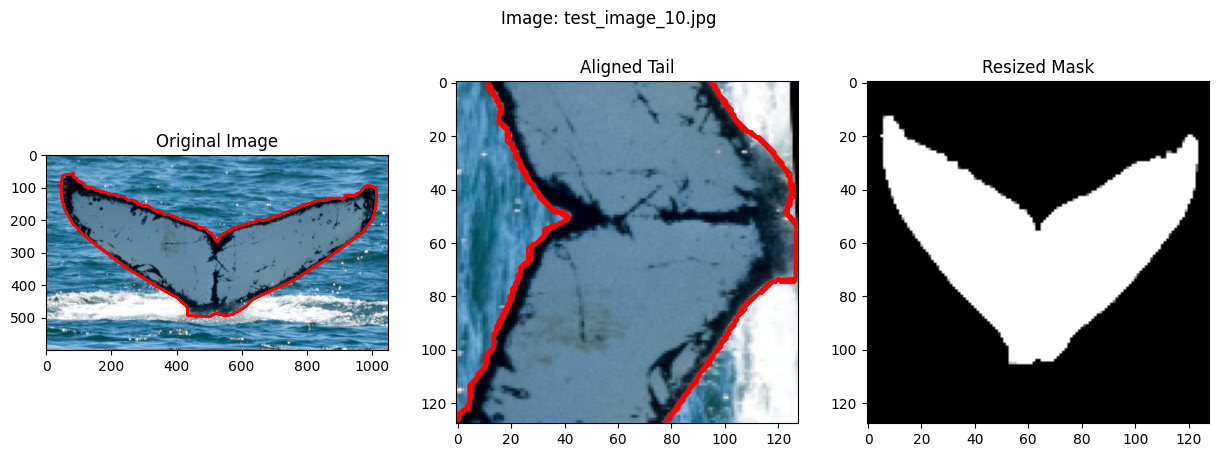

Image: test_image_02.jpg, IoU: 0.2489830378386676


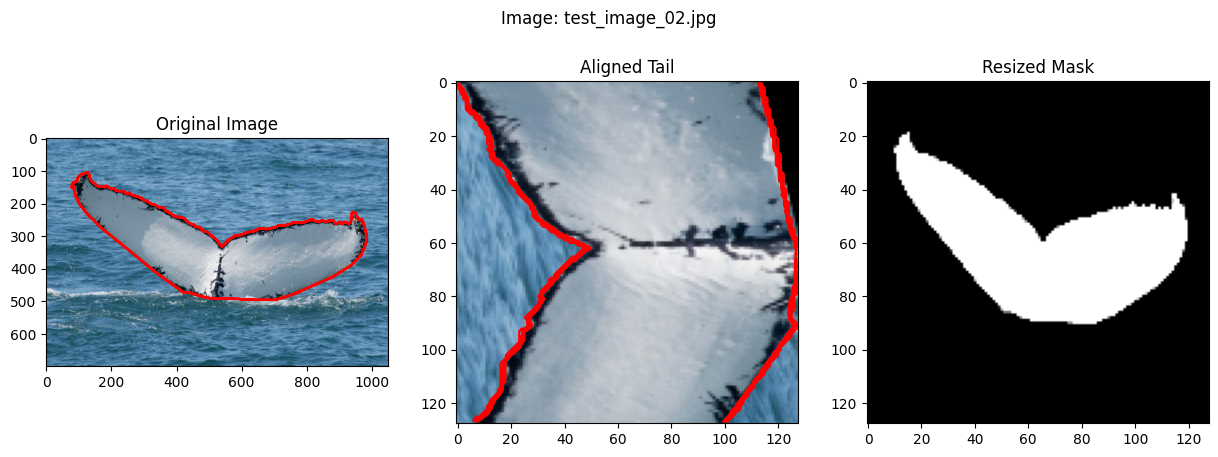

Image: test_image_08.jpg, IoU: 0.1593209780408036


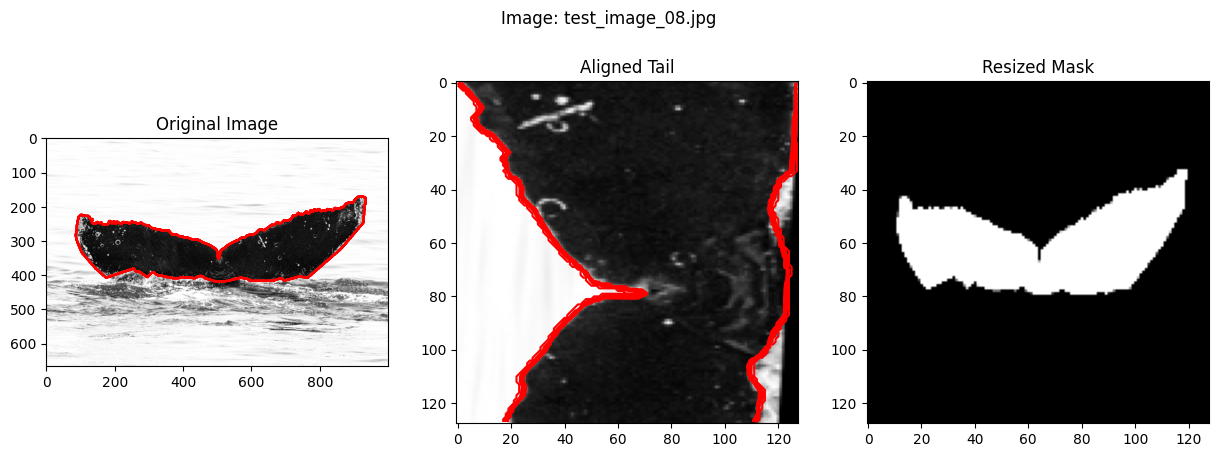

Image: test_image_01.jpg, IoU: 0.54117742987606


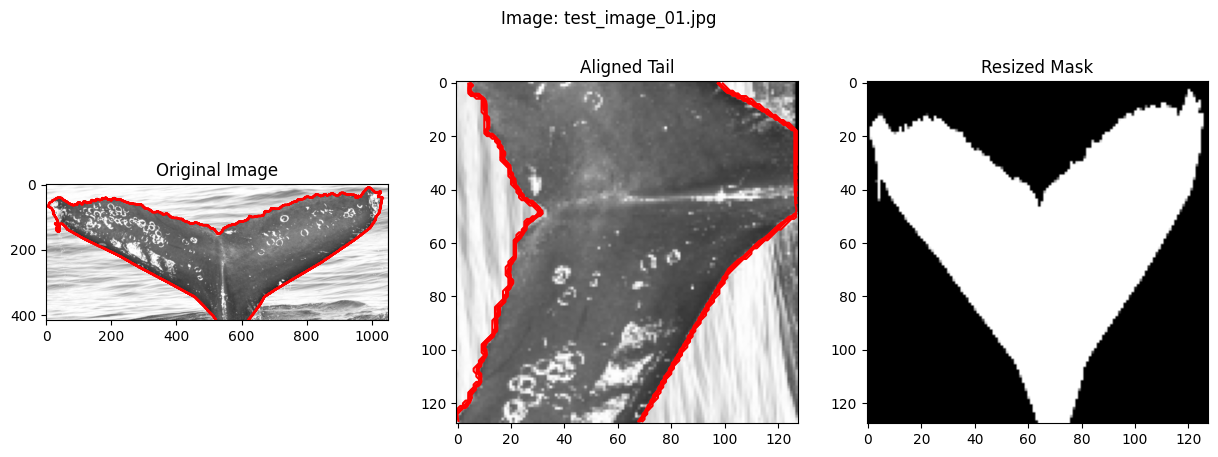

Image: test_image_00.jpg, IoU: 0.4005402971634399


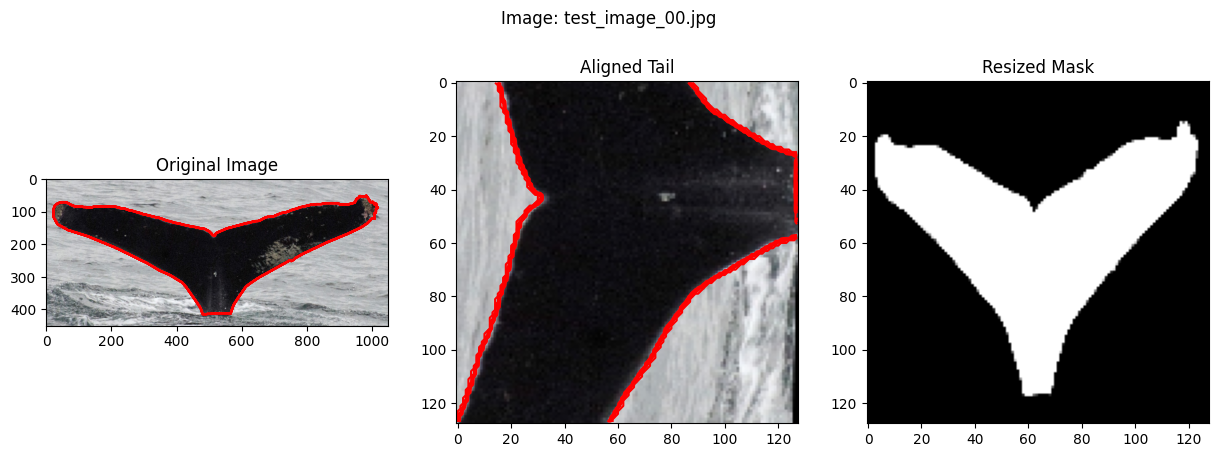

Image: test_image_03.jpg, IoU: 0.17272518558200045


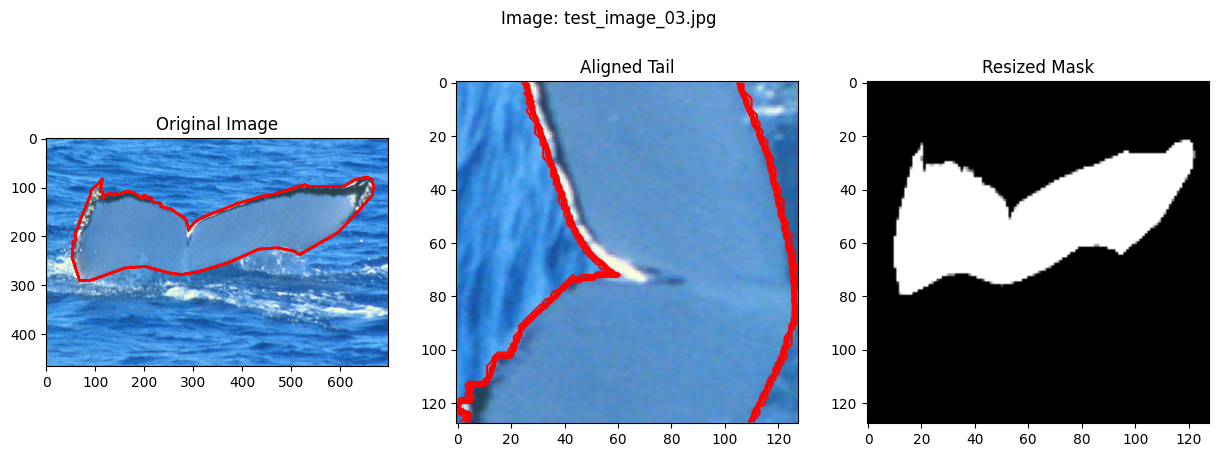

Average IoU: 0.311255056316874


In [16]:
base_dir = 'images/whale_tail'
iou_scores = process_images(base_dir)
print(f'Average IoU: {np.mean(iou_scores)}')

# Задача №2 - Найти шаблон на изображении с помощью HOG и кросс-корреляции

Ваша задача - написать программу, которая сможет найти шаблон одного глаза на нескольких изображениях, в том числе затемненных. Использовать нужно HOG представление изображений, поиск шаблона сделать с помощью кросс-корреляции

Изображение глаз человека и шаблон, который нужно на нем найти, находятся в папке hog

<table><tr>
    <td> <img src="hog/eye.png" alt="Drawing" style="width: 400px;"/>
</tr></table>     

<table><tr>
    <td> <img src="hog/eyes.jpg" alt="Drawing" style="width: 400px;"/> </td>
      <td> <img src="hog/eyes_dark.jpg" alt="Drawing" style="width: 400px;"/> </td>
      <td> <img src="hog/woman.jpg" alt="Drawing" style="width: 200px;"/> </td>

</tr></table>

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog

In [30]:
import cv2
import numpy as np
from skimage.feature import hog
import matplotlib.pyplot as plt

def compute_hog(input_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys'):
    gray_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
    feature_descriptor, hog_visualization = hog(gray_image, orientations=orientations, pixels_per_cell=pixels_per_cell,
                                                cells_per_block=cells_per_block, block_norm=block_norm, visualize=True)
    return feature_descriptor, hog_visualization

def find_best_match(input_image, template_feature_descriptor, template_size, step=8):
    input_image_fd, _ = compute_hog(input_image)
    input_image_fd = input_image_fd.reshape((input_image.shape[0] // 8 - 1, input_image.shape[1] // 8 - 1, -1))

    best_location = (0, 0)
    highest_match_value = -np.inf

    template_hog_image = template_feature_descriptor.reshape(template_size[1] // 8 - 1, template_size[0] // 8 - 1, -1)
    input_image_hog = input_image_fd

    num_channels = template_hog_image.shape[2]
    matching_results = []

    for channel in range(num_channels):
        template_hog_channel = template_hog_image[:, :, channel]
        input_image_channel = input_image_hog[:, :, channel]

        template_hog_channel = cv2.normalize(template_hog_channel, None, 0, 1, cv2.NORM_MINMAX)
        input_image_channel = cv2.normalize(input_image_channel, None, 0, 1, cv2.NORM_MINMAX)

        template_hog_channel = template_hog_channel.astype(np.float32)
        input_image_channel = input_image_channel.astype(np.float32)

        match_result = cv2.matchTemplate(input_image_channel, template_hog_channel, cv2.TM_CCOEFF_NORMED)
        matching_results.append(match_result)

    final_match_result = np.mean(matching_results, axis=0)
    _, max_match_value, _, max_location = cv2.minMaxLoc(final_match_result)

    best_location = (max_location[0] * 8, max_location[1] * 8)
    highest_match_value = max_match_value

    return best_location, highest_match_value

def draw_bounding_box(input_image, match_location, template_size):
    top_left = match_location
    bottom_right = (top_left[0] + template_size[0], top_left[1] + template_size[1])
    cv2.rectangle(input_image, top_left, bottom_right, (0, 255, 0), 2)

def preprocess_image(input_image):
    adjusted_image = cv2.convertScaleAbs(input_image, alpha=1.5, beta=0)
    blurred_image = cv2.GaussianBlur(adjusted_image, (5, 5), 0)
    return blurred_image

def scale_image(input_image, scale_factor):
    return cv2.resize(input_image, (int(input_image.shape[1] * scale_factor), int(input_image.shape[0] * scale_factor)), interpolation=cv2.INTER_LINEAR)


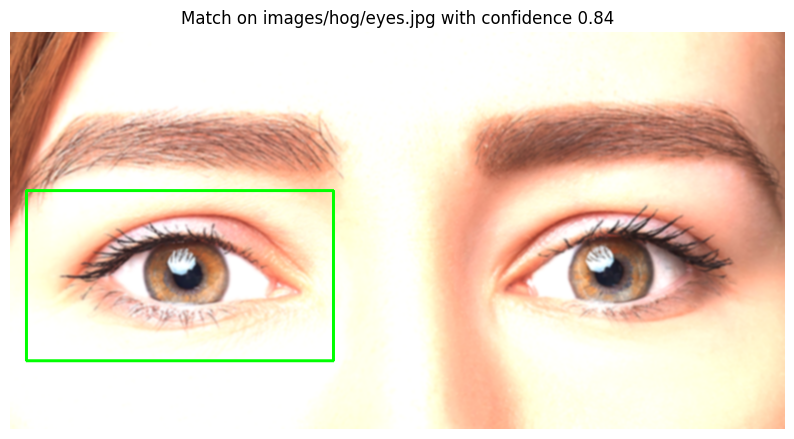

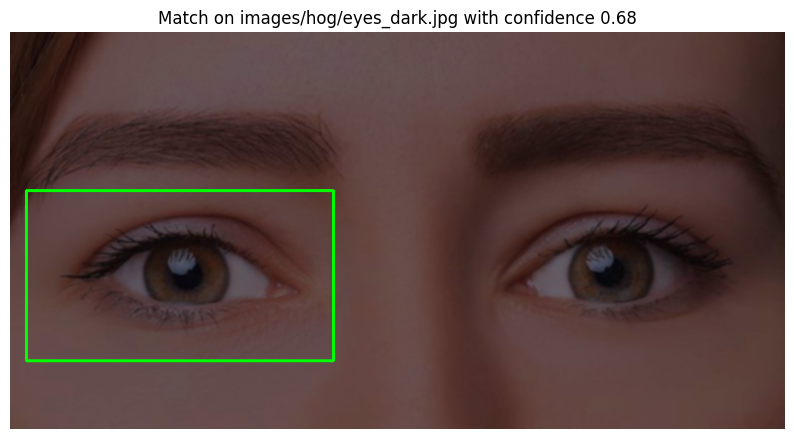

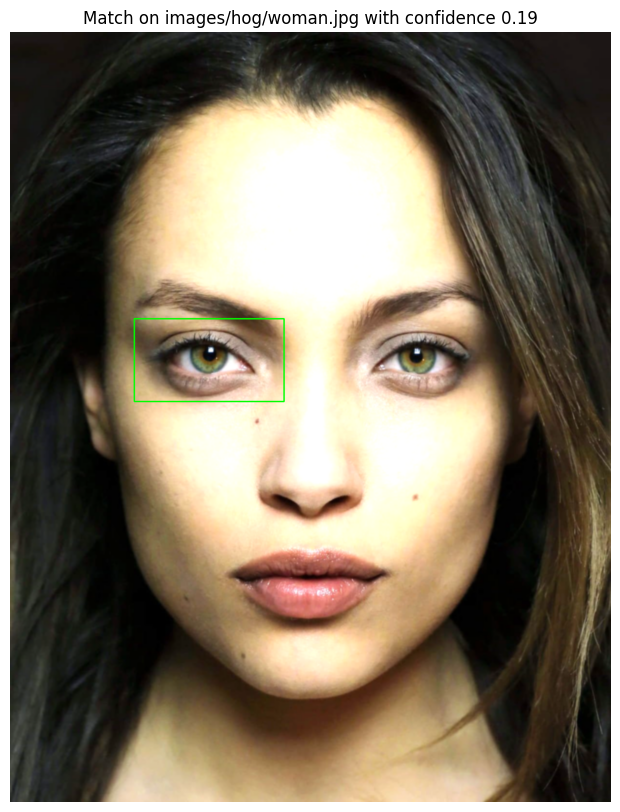

In [31]:
template_path = 'images/hog/eye.png'
template = cv2.imread(template_path)
if template is None:
    raise FileNotFoundError(f"Image file {template_path} not found.")
template = preprocess_image(template)
template_fd, _ = compute_hog(template)

images = ['images/hog/eyes.jpg', 'images/hog/eyes_dark.jpg', 'images/hog/woman.jpg']

for image_name in images:
    image = cv2.imread(image_name)
    if image is None:
        print(f"Image file {image_name} not found.")
        continue
    image = preprocess_image(image)

    best_location = (0, 0)
    best_value = -np.inf

    for scale_factor in [0.8, 1.0, 1.2]:
        scaled_image = scale_image(image, scale_factor)
        location, value = find_best_match(scaled_image, template_fd, (template.shape[1], template.shape[0]))
        location = (int(location[0] / scale_factor), int(location[1] / scale_factor))

        if value > best_value:
            best_value = value
            best_location = location

    draw_bounding_box(image, best_location, (template.shape[1], template.shape[0]))

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f'Match on {image_name} with confidence {best_value:.2f}')
    plt.axis('off')
    plt.show()
